# Red Wine Quality
`redwine-quality.ipynb`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

wine = pd.read_csv('./winequality-red.csv')

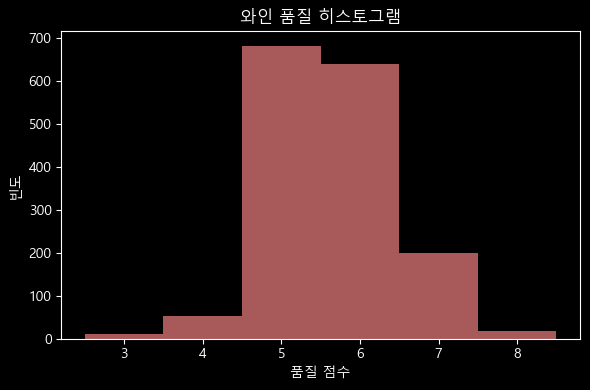

In [2]:
# 특성 살펴보기 (품질 분포, 히스토그램)
plt.figure(figsize=(6, 4))

plt.hist(wine['quality'], bins=np.arange(2.5, 9.5, 1), alpha=0.7, color='lightcoral')
plt.title('와인 품질 히스토그램')
plt.xlabel('품질 점수')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

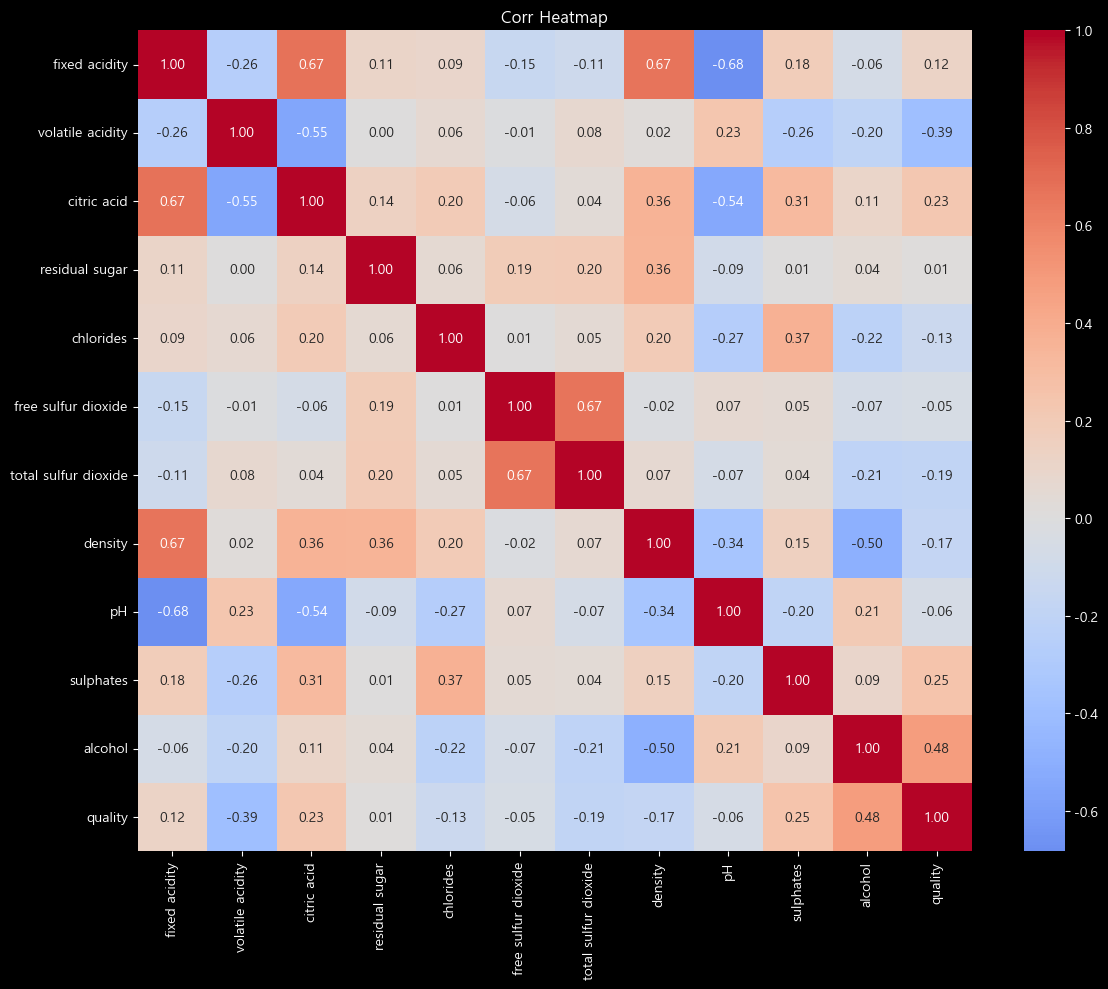

Highest Corr
alcohol: 0.476
volatile acidity: -0.391
sulphates: 0.251
citric acid: 0.226
total sulfur dioxide: -0.185
density: -0.175


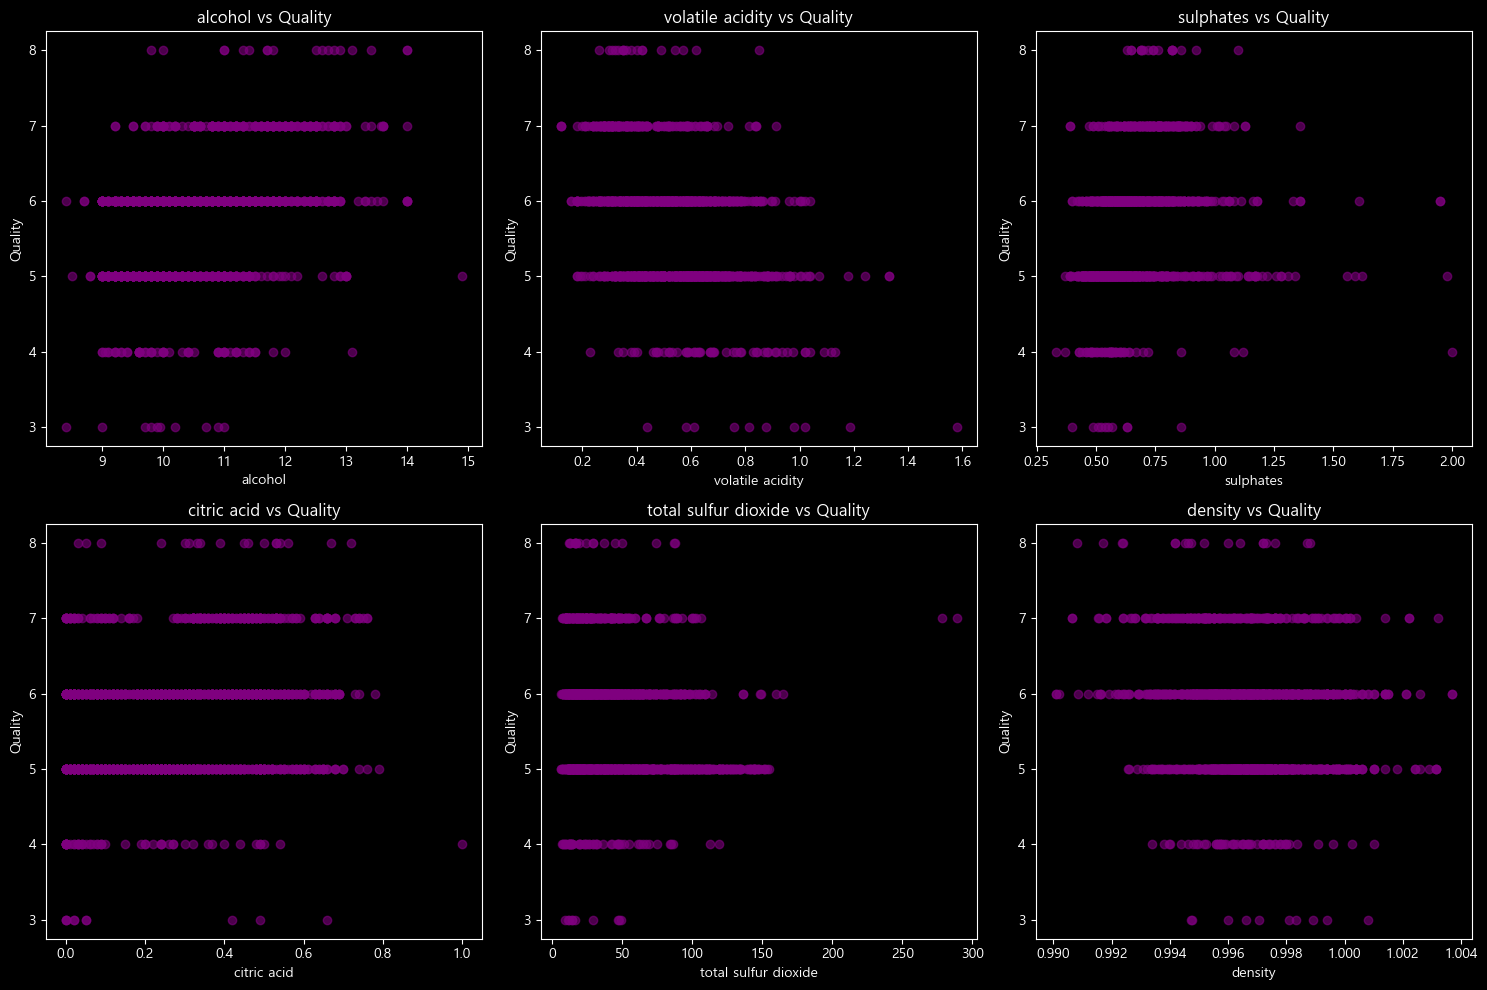

In [3]:
# 품질과의 상관관계 (히트맵) / 품질에 영향을 많이 주는 특성들 시각화
# 상관관계 히트맵
plt.figure(figsize=(12, 10))
correlation = wine.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Corr Heatmap')
plt.tight_layout()
plt.show()

# 품질과 가장 관련 높은 특성들
quality_corr = correlation['quality'].drop('quality').sort_values(key=abs, ascending=False)
print("Highest Corr")
for feature, corr in quality_corr.head(6).items():
    print(f"{feature}: {corr:.3f}")

# 품질에 영향을 많이 주는 특성들 시각화
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

top_features = quality_corr.head(6).index
for i, feature in enumerate(top_features):
    axes[i].scatter(wine[feature], wine['quality'], alpha=0.6, color='purple')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Quality')
    axes[i].set_title(f'{feature} vs Quality')

plt.tight_layout()
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
# 훈련 테스트 셋 나누기
y = wine['quality']
X = wine.drop(['quality'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(f'훈련 데이터: {len(X_train)}')
print(f'테스트 데이터: {len(X_test)}')

훈련 데이터: 1199
테스트 데이터: 400


In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
# KNN 회귀로 와인 품질 예측 
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

k_scores = []

for k in range(1, 31):
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(X_train_scaled, y_train)
    knr_train_score = knr.score(X_train_scaled, y_train)
    knr_test_score = knr.score(X_test_scaled, y_test)
    k_scores.append((k, knr_test_score, knr_train_score))

max_k, max_test_score, max_train_score = max(k_scores, key=lambda x: x[1])
print(f'최고점수 k: {max_k}, 점수: {max_test_score:.4f}')

# best_knr = KNeighborsRegressor(n_neighbors=max_k)

최고점수 k: 14, 점수: 0.3504


In [6]:
from sklearn.linear_model import LinearRegression
# 선형회귀로 와인 품질 예측 (훈련셋/테스트셋의 점수를 높여보자)

lr_basic = LinearRegression()
lr_basic.fit(X_train, y_train)

lr_basic_score = lr_basic.score(X_test, y_test)

print(f'기본 LR Score(R^2): {lr_basic_score:.4f} (Train: {lr_basic.score(X_train, y_train)})')

# 예측 실제 값 계산(시각화)
lr_basic_pred = lr_basic.predict(X_test)

기본 LR Score(R^2): 0.3723 (Train: 0.354852874520566)


In [7]:
from sklearn.preprocessing import PolynomialFeatures
# 다항 회귀 (스케일링 필요)
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

poly_results = []
for degree in [2, 3, 4]:
    print(f'\n{degree}차수 다항식 특성 실험')
    # 다항식 특성 생성
    
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    print(f'원래 특성 수: {X_train_scaled.shape[1]}')
    print(f'다항식 특성 수: {X_train_poly.shape[1]}')

    # 모델 훈련
    lr_poly = LinearRegression()
    lr_poly.fit(X_train_poly, y_train)

    # 성능 평가
    poly_score = lr_poly.score(X_test_poly, y_test)
    poly_results.append((degree, poly_score))
    print(f'다항식 차수별 점수: {degree} -> {poly_score:.4f}')

    # Overfitting 체크를 위한 성능 확인
    train_score = lr_poly.score(X_train_poly, y_train)
    print(f'훈련 -> {train_score:.4f}')
    print(f'과적합정도 -> {train_score - poly_score:.4f}')


best_degree, best_score = max(poly_results, key=lambda x: x[1])
print(best_degree, best_score)

# 시각화를 위해 다시 훈련
poly_best = PolynomialFeatures(degree=best_degree)
X_train_poly_best = poly_best.fit_transform(X_train_scaled)
X_test_poly_best = poly_best.transform(X_test_scaled)

lr_poly_best = LinearRegression()
lr_poly_best.fit(X_train_poly_best, y_train)
lr_poly_best_score = lr_poly_best.score(X_test_poly_best, y_test)
lr_poly_best_pred = lr_poly_best.predict(X_test_poly_best)


2차수 다항식 특성 실험
원래 특성 수: 11
다항식 특성 수: 77
다항식 차수별 점수: 2 -> 0.3745
훈련 -> 0.4389
과적합정도 -> 0.0644

3차수 다항식 특성 실험
원래 특성 수: 11
다항식 특성 수: 363
다항식 차수별 점수: 3 -> -0.3482
훈련 -> 0.6528
과적합정도 -> 1.0010

4차수 다항식 특성 실험
원래 특성 수: 11
다항식 특성 수: 1364
다항식 차수별 점수: 4 -> -3185.0570
훈련 -> 1.0000
과적합정도 -> 3186.0570
2 0.37445416528963726


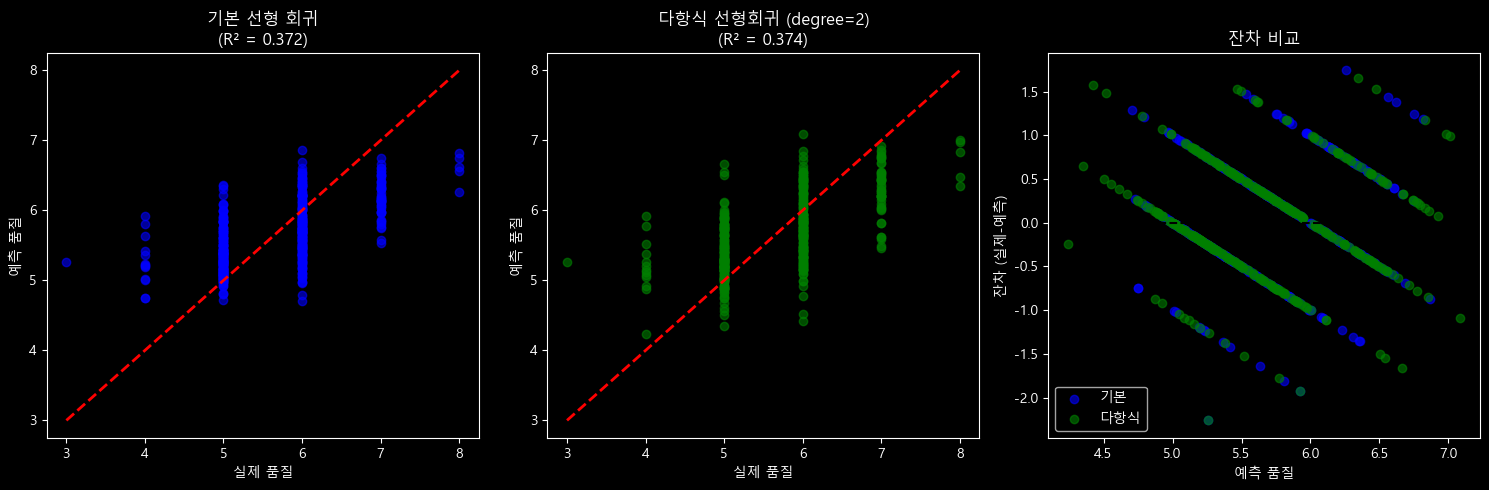

성능 향상: 0.0022 (0.6%)


In [8]:
# 예측 vs 실제값 비교
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, lr_basic_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제 품질')
plt.ylabel('예측 품질')
plt.title(f'기본 선형 회귀\n(R² = {lr_basic_score:.3f})')

plt.subplot(1, 3, 2)
plt.scatter(y_test, lr_poly_best_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('실제 품질')
plt.ylabel('예측 품질')
plt.title(f'다항식 선형회귀 (degree={best_degree})\n(R² = {lr_poly_best_score:.3f})')

plt.subplot(1, 3, 3)
# 잔차 비교
residuals_basic = y_test - lr_basic_pred
residuals_poly = y_test - lr_poly_best_pred

plt.scatter(lr_basic_pred, residuals_basic, alpha=0.6, color='blue', label='기본')
plt.scatter(lr_poly_best_pred, residuals_poly, alpha=0.6, color='green', label='다항식')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('예측 품질')
plt.ylabel('잔차 (실제-예측)')
plt.title('잔차 비교')
plt.legend()

plt.tight_layout()
plt.show()

improvement = lr_poly_best_score - lr_basic_score
print(f"성능 향상: {improvement:.4f} ({improvement/lr_basic_score*100:.1f}%)")


In [9]:
from sklearn.linear_model import Ridge, Lasso

# 다항식 특성에 대해 Ridge/Lasso 적용 (앞서 만든 최적 degree 사용)
print(f"다항식 특성 (degree={best_degree}) 데이터 사용:")
print(f"특성 수: {X_train_poly_best.shape[1]}개")

# Ridge 회귀 (다항식 특성에 대해)
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
ridge_scores_poly = []
ridge_train_scores = []

print("\nRidge 회귀 (다항식 특성):")
for alpha in alphas:
    ridge_poly = Ridge(alpha=alpha)
    ridge_poly.fit(X_train_poly_best, y_train)
    
    # 테스트 성능
    ridge_score = ridge_poly.score(X_test_poly_best, y_test)
    ridge_scores_poly.append(ridge_score)
    
    # 훈련 성능 (과적합 체크용)
    ridge_train_score = ridge_poly.score(X_train_poly_best, y_train)
    ridge_train_scores.append(ridge_train_score)
    
    print(f"  alpha={alpha:7.3f}: 테스트={ridge_score:.4f}, 훈련={ridge_train_score:.4f}, 차이={ridge_train_score-ridge_score:.4f}")

best_ridge_alpha_poly = alphas[np.argmax(ridge_scores_poly)]
best_ridge_score_poly = max(ridge_scores_poly)

# Lasso 회귀 (다항식 특성에 대해)
lasso_scores_poly = []
lasso_train_scores = []

print("\nLasso 회귀 (다항식 특성):")
for alpha in alphas:
    lasso_poly = Lasso(alpha=alpha, max_iter=2000)
    lasso_poly.fit(X_train_poly_best, y_train)
    
    # 테스트 성능
    lasso_score = lasso_poly.score(X_test_poly_best, y_test)
    lasso_scores_poly.append(lasso_score)
    
    # 훈련 성능
    lasso_train_score = lasso_poly.score(X_train_poly_best, y_train)
    lasso_train_scores.append(lasso_train_score)
    
    print(f"  alpha={alpha:7.3f}: 테스트={lasso_score:.4f}, 훈련={lasso_train_score:.4f}, 차이={lasso_train_score-lasso_score:.4f}")

best_lasso_alpha_poly = alphas[np.argmax(lasso_scores_poly)]
best_lasso_score_poly = max(lasso_scores_poly)

print(f"\n🏆 최적 성능:")
print(f"Ridge (다항식) - alpha: {best_ridge_alpha_poly}, Score: {best_ridge_score_poly:.4f}")
print(f"Lasso (다항식) - alpha: {best_lasso_alpha_poly}, Score: {best_lasso_score_poly:.4f}")

다항식 특성 (degree=2) 데이터 사용:
특성 수: 78개

Ridge 회귀 (다항식 특성):
  alpha=  0.001: 테스트=0.3745, 훈련=0.4389, 차이=0.0644
  alpha=  0.010: 테스트=0.3745, 훈련=0.4389, 차이=0.0644
  alpha=  0.100: 테스트=0.3745, 훈련=0.4389, 차이=0.0643
  alpha=  1.000: 테스트=0.3753, 훈련=0.4388, 차이=0.0635
  alpha= 10.000: 테스트=0.3799, 훈련=0.4374, 차이=0.0575
  alpha=100.000: 테스트=0.3929, 훈련=0.4258, 차이=0.0329
  alpha=1000.000: 테스트=0.3496, 훈련=0.3498, 차이=0.0002

Lasso 회귀 (다항식 특성):
  alpha=  0.001: 테스트=0.3835, 훈련=0.4362, 차이=0.0527
  alpha=  0.010: 테스트=0.3904, 훈련=0.4104, 차이=0.0200
  alpha=  0.100: 테스트=0.3090, 훈련=0.3057, 차이=-0.0033
  alpha=  1.000: 테스트=-0.0020, 훈련=0.0000, 차이=0.0020
  alpha= 10.000: 테스트=-0.0020, 훈련=0.0000, 차이=0.0020
  alpha=100.000: 테스트=-0.0020, 훈련=0.0000, 차이=0.0020
  alpha=1000.000: 테스트=-0.0020, 훈련=0.0000, 차이=0.0020

🏆 최적 성능:
Ridge (다항식) - alpha: 100.0, Score: 0.3929
Lasso (다항식) - alpha: 0.01, Score: 0.3904


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

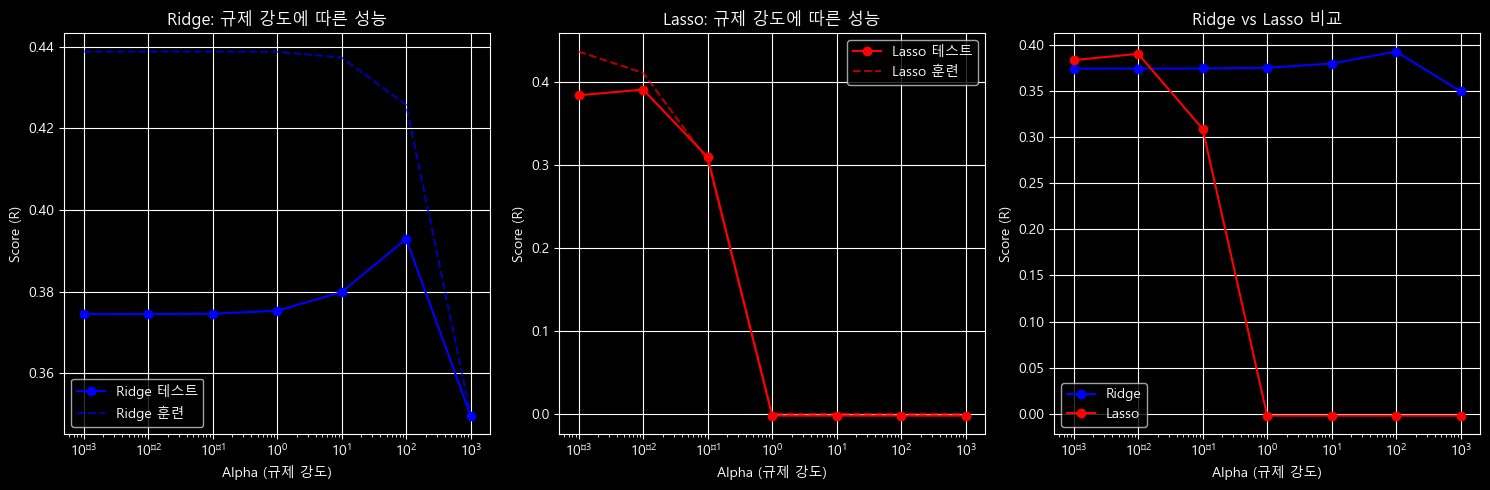

In [10]:
# Alpha 값에 따른 성능 비교 (훈련 vs 테스트)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(alphas, ridge_scores_poly, 'bo-', label='Ridge 테스트')
plt.plot(alphas, ridge_train_scores, 'b--', alpha=0.7, label='Ridge 훈련')
plt.xlabel('Alpha (규제 강도)')
plt.ylabel('Score (R)')
plt.title('Ridge: 규제 강도에 따른 성능')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(alphas, lasso_scores_poly, 'ro-', label='Lasso 테스트')
plt.plot(alphas, lasso_train_scores, 'r--', alpha=0.7, label='Lasso 훈련')
plt.xlabel('Alpha (규제 강도)')
plt.ylabel('Score (R)')
plt.title('Lasso: 규제 강도에 따른 성능')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(alphas, ridge_scores_poly, 'bo-', label='Ridge')
plt.plot(alphas, lasso_scores_poly, 'ro-', label='Lasso')
plt.xlabel('Alpha (규제 강도)')
plt.ylabel('Score (R)')
plt.title('Ridge vs Lasso 비교')
plt.xscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
